# IT5006 Group Project - FD001


## Experiment 1: Traditional Machine Learning without Tsfresh
**Group 6**

Gong Yifei (A0275740B)  
Jiao Yuehan (A0290548W)  
Loh Hui Wen (A0274301R)  
Tan Xin Ying Geraldine (A0274591W)   
Zhang Junti (A0274854R)

For this dataset, we conducted:
- **Experiment 1**: Traditional Machine Learning without Tsfresh
- **Experiment 2**: Various ML & DL Models Using Selected Sensors with Tsfresh 
- **Experiment 3**: Various ML & DL Models Using All Features with Tsfresh

### 1.1 Load train data

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime

from scipy.stats import skew, kurtosis
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler


In [2]:
col_names = ['unit_id', 'cycle', 'sys1', 'sys2', 'sys3'] + [f"sensor{i}" for i in range(1, 22)]

df = pd.read_csv('C:\\Users\\owner\\Desktop\\IT5006\\CMAPSSData\\train_FD001.txt', delim_whitespace=True, header=None, names=col_names)

### 1.2 Perform basic checks
#### Check for null/missing values
For FD001 we don't see null values:

In [3]:
for col in df.columns:
    if(df[col].isnull().any()):
        print("Column ",col," has null value(s).")
        df[col] = df.groupby('unit_id')[col].transform(lambda x: x.fillna(x.mean()))
# df.describe()

#### Find missing cycle per unit (if any)
For FD001 we don't see missing cycles in the raw data:

In [4]:
def find_missing_cycles(df):
    missing_cycles = {}
    for unit_id, group in df.groupby('unit_id'):
        actual_cycles = group['cycle'].values
        expected_cycles = list(range(1, group['cycle'].max() + 1))  # Create the expected cycle sequence
        missing = sorted(set(expected_cycles) - set(actual_cycles))  # Compare and find missing cycles
        if missing:
            missing_cycles[unit_id] = missing
    return missing_cycles

missing_cycles = find_missing_cycles(df)
if (len(missing_cycles)):
    print(missing_cycles)

### 1.3 Add Remaining Useful Life (RUL) as target

In [5]:
df['RUL'] = df.groupby('unit_id')['cycle'].transform(lambda x: x.max() - x).clip(upper=130)
#df

### 1.4 Exploratory Data Analysis
#### Statistical summary

In [6]:
print(df.shape)
pd.set_option('display.max_columns', None)
df.describe()

(20631, 27)


,unit_id,cycle,sys1,sys2,sys3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,553.367711,2388.096652,9065.242941,1.300000e+00,47.541168,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,88.727304
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,0.001389,0.885092,0.070985,22.082880,4.660829e-13,0.267087,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251,43.444137
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,2387.900000,9021.730000,1.300000e+00,46.850000,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,552.810000,2388.050000,9053.100000,1.300000e+00,47.350000,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,51.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,553.440000,2388.090000,9060.660000,1.300000e+00,47.510000,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,103.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,554.010000,2388.140000,9069.420000,1.300000e+00,47.700000,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,130.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000,2388.560000,9244.590000,1.300000e+00,48.530000,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,130.000000


#### Box plot

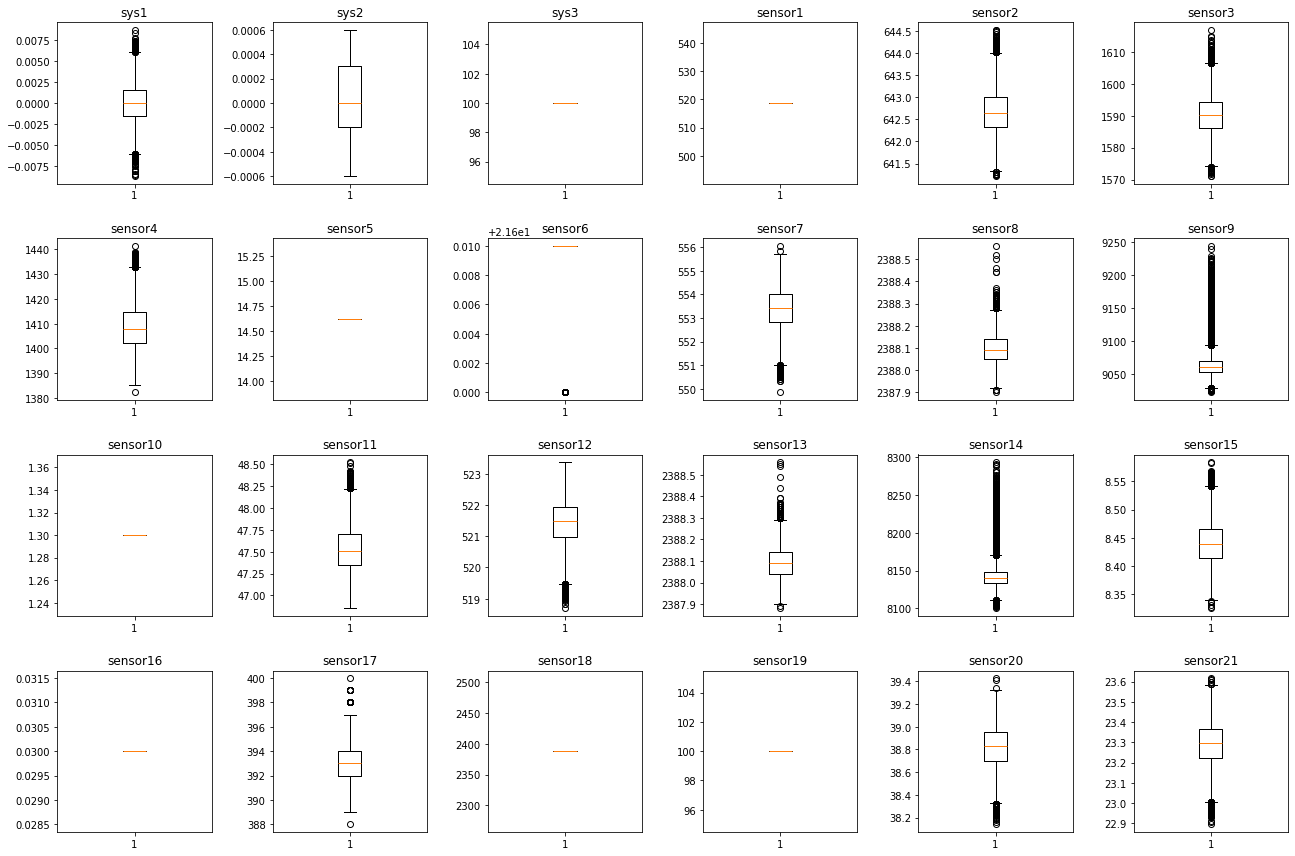

In [10]:
# Create a grid of subplots
unit_id = 1
cols = df.columns
cols = cols[~cols.isin(['unit_id', 'cycle', 'RUL'])]

fig, axes = plt.subplots(4, 6, figsize = (18, 12))
axes = axes.flatten()

for i, col in enumerate(cols):
    axes[i].boxplot(df[col])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

By analysing the box plots above, we can find fields 'sys3', 'sensor1', 'sensor5', 'sensor16', 'sensor18' and 'sensor19' are not changing much through the entire engine life, therefore we can drop them directly.

For sensor10, we can dig a bit deeper:

In [12]:
print("Sensor6 variance: ", df['sensor6'].var())
df['sensor6'].value_counts()

Sensor6 variance:  1.9292790877278185e-06


21.61    20225
21.60      406
Name: sensor6, dtype: int64

With a variance of 1.21e-5, and values not differenciate much (about 90% of instances being the same value with min-max spread of 0.03), we can confidently drop it as well.

In [13]:
static_cols = ['sys3', 'sensor1', 'sensor5', 'sensor6', 'sensor10', 'sensor16', 'sensor18', 'sensor19'];
df.drop(columns=static_cols, inplace=True)

#### Crrelation heatmap

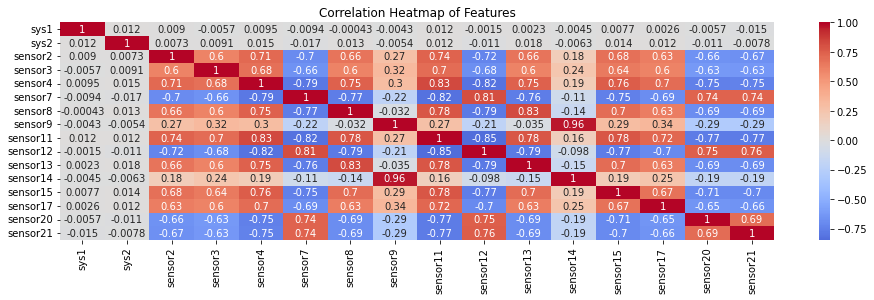

In [14]:
cols = cols[~cols.isin(static_cols)]
correlation_matrix = df[cols].corr()
plt.figure(figsize=(16, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

plt.title('Correlation Heatmap of Features')
plt.show()

We use threshold of 0.99 to remove highly correlated features. Because of which, we keep all features from previous step.

#### Line plot of one unit

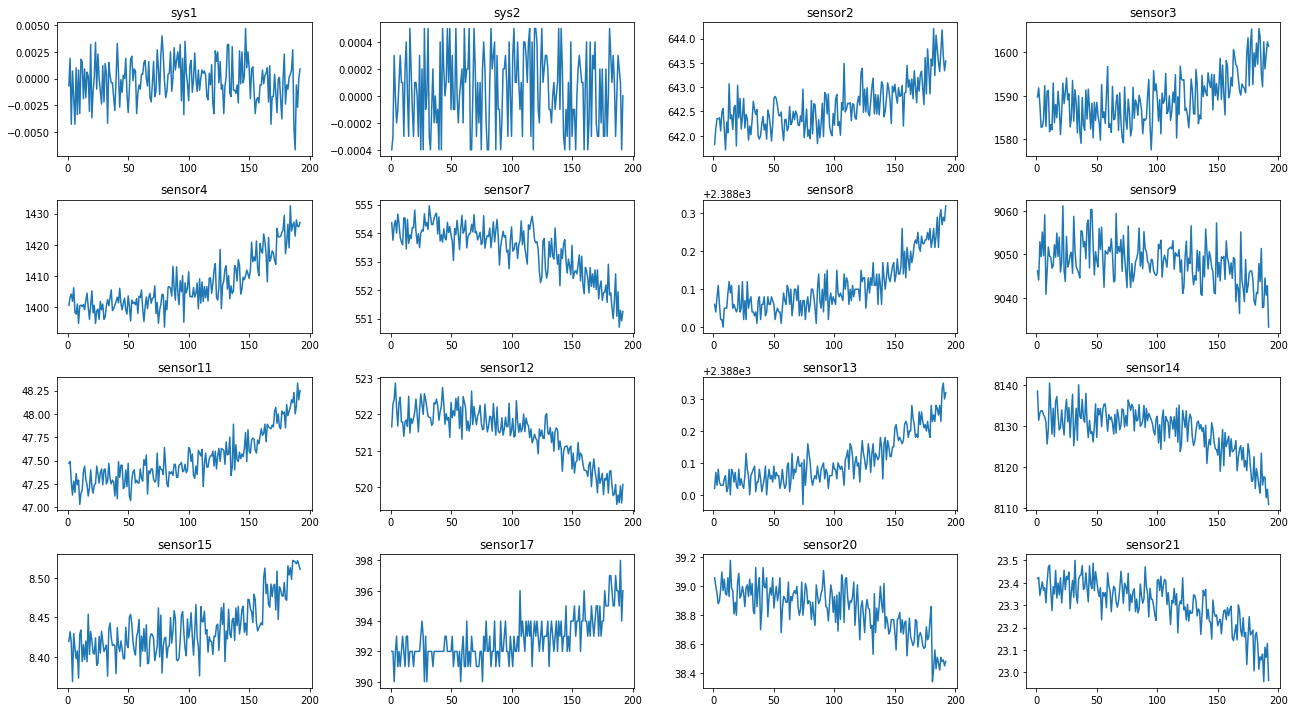

In [15]:
# Create a grid of subplots
unit_id = 1
unit_df = df[df['unit_id'] == unit_id]

fig, axes = plt.subplots(4, 4, figsize = (18, 10))
axes = axes.flatten()

for i, col in enumerate(cols):
    axes[i].plot(unit_df['cycle'], unit_df[col])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

For all features except sys2, we can see a trend moving up or down. Sys2 looks random but at least not static. We'll use all of them in the next step.

In [16]:
print(cols)

Index(['sys1', 'sys2', 'sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8',
       'sensor9', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
       'sensor17', 'sensor20', 'sensor21'],
      dtype='object')


### 1.5 Feature Engineering
#### Create new features

In [17]:
def create_features(df, window_size):
    # Initialize new features dataframe
    features = pd.DataFrame()
    features['unit_id'] = df['unit_id']
    features['cycle'] = df['cycle']

    # 1. Static statistical features
    sensor_cols = [col for col in df.columns if col.startswith('sensor')]
    agg_dict = {col: ['mean', 'std', 'min', 'max', 'var', skew, kurtosis] for col in sensor_cols}
    statistical_features = df.groupby('unit_id').agg(agg_dict)
    statistical_features.columns = ['_static_'.join(col) for col in statistical_features.columns]
    features = features.merge(statistical_features, on='unit_id', how='left')

    # 2. Rolling statistical features (using window_size)
    rolling_window = []
    stat_functions = {
        'mean': np.mean,
        'std': np.std,
        'min': np.min,
        'max': np.max,
        'var': np.var,
        'skew': skew,
        'kurtosis': kurtosis
    }
    
    for stat_name, stat_function in stat_functions.items():
        rolling_result = df.groupby('unit_id').rolling(window=window_size, on='cycle')[sensor_cols].apply(stat_function).reset_index()
        rolling_result = rolling_result[sensor_cols]
        rolling_result.columns = [f'{col}_rolling_{stat_name}' for col in sensor_cols]
        rolling_window.append(rolling_result)
    
    rolling_window = pd.concat(rolling_window, axis=1)
    features = pd.concat([features, rolling_window], axis=1)

    # 3. Immediate diff feature
    for col in sensor_cols:
        features[f'{col}_diff'] = df.groupby('unit_id')[col].diff()

    # 4. Rolling trend features
    for col in sensor_cols:
        slopes = []
        for unit_id in df['unit_id'].unique():
            unit_data = df[df['unit_id'] == unit_id]
            for i in range(len(unit_data)):
                if i < window_size - 1:
                    slopes.append(0)
                else:
                    y = unit_data.iloc[i-window_size+1:i+1][col].values
                    x = np.array(range(window_size)).reshape(-1, 1)
                    model = LinearRegression().fit(x, y)
                    slopes.append(model.coef_[0])
        features[f'{col}_rolling_slope'] = slopes

    # 5. Lag features
    lag_values = [5, 10]
    for col in sensor_cols:
        for lag in lag_values:
            features[f'{col}_lag_{lag}'] = df.groupby('unit_id')[col].shift(lag)

    # 6. Rolling lag features
    rolling_lag_values = [5, 10]
    for col in sensor_cols:
        for lag in rolling_lag_values:
            features[f'{col}_rolling_lag_{lag}'] = df.groupby('unit_id')[col].shift(lag).rolling(window=window_size).mean()
                
    df_with_features = pd.concat([df, features.drop(columns=['unit_id', 'cycle']).reset_index(drop=True)], axis=1)
    return df_with_features


def create_temperature_pressure_ratio_features(df, window_size):
    # Create ratios for temperature sensors 1, 2, 3, 4 against pressure sensors 5, 6, 7
    # After dropping highly correlated and near-constant featrures, this map is reduced to sensors 2, 3, 4 to sensor 7
    sensor_numerators = ['sensor2', 'sensor3', 'sensor4']
    sensor_denominators = ['sensor7']

    for num in sensor_numerators:
        for denom in sensor_denominators:
            df[f'tp_ratio_{num}_to_{denom}'] = df[num] / (df[denom] + 1e-6) # add a small number to avoid division by 0
            df[f'rolling_mean_ratio_{num}_to_{denom}'] = df[f'{num}_rolling_mean'] / (df[f'{denom}_rolling_mean'] + 1e-6)

    return df

As we observed from previous literature review, we'll start with rolling window of 30, which is a common window size chosen by majority of previous researches.

In [18]:
window_size = 30
train_df = create_features(df, window_size)
train_df = create_temperature_pressure_ratio_features(train_df, window_size)
train_df.head()

,unit_id,cycle,sys1,sys2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,RUL,sensor2_static_mean,sensor2_static_std,sensor2_static_min,sensor2_static_max,sensor2_static_var,sensor2_static_skew,sensor2_static_kurtosis,sensor3_static_mean,sensor3_static_std,sensor3_static_min,sensor3_static_max,sensor3_static_var,sensor3_static_skew,sensor3_static_kurtosis,sensor4_static_mean,sensor4_static_std,sensor4_static_min,sensor4_static_max,sensor4_static_var,sensor4_static_skew,sensor4_static_kurtosis,sensor7_static_mean,sensor7_static_std,sensor7_static_min,sensor7_static_max,sensor7_static_var,sensor7_static_skew,sensor7_static_kurtosis,sensor8_static_mean,sensor8_static_std,sensor8_static_min,sensor8_static_max,sensor8_static_var,sensor8_static_skew,sensor8_static_kurtosis,sensor9_static_mean,sensor9_static_std,sensor9_static_min,sensor9_static_max,sensor9_static_var,sensor9_static_skew,sensor9_static_kurtosis,sensor11_static_mean,sensor11_static_std,sensor11_static_min,sensor11_static_max,sensor11_static_var,sensor11_static_skew,sensor11_static_kurtosis,sensor12_static_mean,sensor12_static_std,sensor12_static_min,sensor12_static_max,sensor12_static_var,sensor12_static_skew,sensor12_static_kurtosis,sensor13_static_mean,sensor13_static_std,sensor13_static_min,sensor13_static_max,sensor13_static_var,sensor13_static_skew,sensor13_static_kurtosis,sensor14_static_mean,sensor14_static_std,sensor14_static_min,sensor14_static_max,sensor14_static_var,sensor14_static_skew,sensor14_static_kurtosis,sensor15_static_mean,sensor15_static_std,sensor15_static_min,sensor15_static_max,sensor15_static_var,sensor15_static_skew,sensor15_static_kurtosis,sensor17_static_mean,sensor17_static_std,sensor17_static_min,sensor17_static_max,sensor17_static_var,sensor17_static_skew,sensor17_static_kurtosis,sensor20_static_mean,sensor20_static_std,sensor20_static_min,sensor20_static_max,sensor20_static_var,sensor20_static_skew,sensor20_static_kurtosis,sensor21_static_mean,sensor21_static_std,sensor21_static_min,sensor21_static_max,sensor21_static_var,sensor21_static_skew,sensor21_static_kurtosis,sensor2_rolling_mean,sensor3_rolling_mean,sensor4_rolling_mean,sensor7_rolling_mean,sensor8_rolling_mean,sensor9_rolling_mean,sensor11_rolling_mean,sensor12_rolling_mean,sensor13_rolling_mean,sensor14_rolling_mean,sensor15_rolling_mean,sensor17_rolling_mean,sensor20_rolling_mean,sensor21_rolling_mean,sensor2_rolling_std,sensor3_rolling_std,sensor4_rolling_std,sensor7_rolling_std,sensor8_rolling_std,sensor9_rolling_std,sensor11_rolling_std,sensor12_rolling_std,sensor13_rolling_std,sensor14_rolling_std,sensor15_rolling_std,sensor17_rolling_std,sensor20_rolling_std,sensor21_rolling_std,sensor2_rolling_min,sensor3_rolling_min,sensor4_rolling_min,sensor7_rolling_min,sensor8_rolling_min,sensor9_rolling_min,sensor11_rolling_min,sensor12_rolling_min,sensor13_rolling_min,sensor14_rolling_min,sensor15_rolling_min,sensor17_rolling_min,sensor20_rolling_min,sensor21_rolling_min,sensor2_rolling_max,sensor3_rolling_max,sensor4_rolling_max,sensor7_rolling_max,sensor8_rolling_max,sensor9_rolling_max,sensor11_rolling_max,sensor12_rolling_max,sensor13_rolling_max,sensor14_rolling_max,sensor15_rolling_max,sensor17_rolling_max,sensor20_rolling_max,sensor21_rolling_max,sensor2_rolling_var,sensor3_rolling_var,sensor4_rolling_var,sensor7_rolling_var,sensor8_rolling_var,sensor9_rolling_var,sensor11_rolling_var,sensor12_rolling_var,sensor13_rolling_var,sensor14_rolling_var,sensor15_rolling_var,sensor17_rolling_var,sensor20_rolling_var,sensor21_rolling_var,sensor2_rolling_skew,sensor3_rolling_skew,sensor4_rolling_skew,sensor7_rolling_skew,sensor8_rolling_skew,sensor9_rolling_skew,sensor11_rolling_skew,sensor12_rolling_skew,sensor13_rolling_skew,sensor14_rolling_skew,sensor15_rolling_skew,sensor17_rolling_skew,sensor20_rolling_skew,sensor21_rolling_skew,sensor2_rolling_kurtosis,sensor3_rolling_kurtosis,sensor4_rolling_kurtosis,sens

#### Pre-processing all features

In [19]:
# Handle missing values by replacing infinite values and dropping NaNs
train_df = train_df.replace([np.inf, -np.inf], np.nan).dropna()
train_df = train_df.apply(pd.to_numeric, errors='coerce').dropna()

train_df_features = train_df.drop(columns=['unit_id','cycle','RUL'])
train_df_seq = train_df[['unit_id','cycle']]
train_df_target = train_df['RUL']

# Min-Max scaling
scaler = MinMaxScaler()
scaler.fit(train_df_features)

train_df_features_scaled = pd.DataFrame(scaler.fit_transform(train_df_features), columns=train_df_features.columns, index=train_df_features.index)
train_df_scaled = pd.concat([train_df_seq, train_df_features_scaled, train_df_target], axis=1)

train_df_scaled.describe()

,unit_id,cycle,sys1,sys2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,sensor2_static_mean,sensor2_static_std,sensor2_static_min,sensor2_static_max,sensor2_static_var,sensor2_static_skew,sensor2_static_kurtosis,sensor3_static_mean,sensor3_static_std,sensor3_static_min,sensor3_static_max,sensor3_static_var,sensor3_static_skew,sensor3_static_kurtosis,sensor4_static_mean,sensor4_static_std,sensor4_static_min,sensor4_static_max,sensor4_static_var,sensor4_static_skew,sensor4_static_kurtosis,sensor7_static_mean,sensor7_static_std,sensor7_static_min,sensor7_static_max,sensor7_static_var,sensor7_static_skew,sensor7_static_kurtosis,sensor8_static_mean,sensor8_static_std,sensor8_static_min,sensor8_static_max,sensor8_static_var,sensor8_static_skew,sensor8_static_kurtosis,sensor9_static_mean,sensor9_static_std,sensor9_static_min,sensor9_static_max,sensor9_static_var,sensor9_static_skew,sensor9_static_kurtosis,sensor11_static_mean,sensor11_static_std,sensor11_static_min,sensor11_static_max,sensor11_static_var,sensor11_static_skew,sensor11_static_kurtosis,sensor12_static_mean,sensor12_static_std,sensor12_static_min,sensor12_static_max,sensor12_static_var,sensor12_static_skew,sensor12_static_kurtosis,sensor13_static_mean,sensor13_static_std,sensor13_static_min,sensor13_static_max,sensor13_static_var,sensor13_static_skew,sensor13_static_kurtosis,sensor14_static_mean,sensor14_static_std,sensor14_static_min,sensor14_static_max,sensor14_static_var,sensor14_static_skew,sensor14_static_kurtosis,sensor15_static_mean,sensor15_static_std,sensor15_static_min,sensor15_static_max,sensor15_static_var,sensor15_static_skew,sensor15_static_kurtosis,sensor17_static_mean,sensor17_static_std,sensor17_static_min,sensor17_static_max,sensor17_static_var,sensor17_static_skew,sensor17_static_kurtosis,sensor20_static_mean,sensor20_static_std,sensor20_static_min,sensor20_static_max,sensor20_static_var,sensor20_static_skew,sensor20_static_kurtosis,sensor21_static_mean,sensor21_static_std,sensor21_static_min,sensor21_static_max,sensor21_static_var,sensor21_static_skew,sensor21_static_kurtosis,sensor2_rolling_mean,sensor3_rolling_mean,sensor4_rolling_mean,sensor7_rolling_mean,sensor8_rolling_mean,sensor9_rolling_mean,sensor11_rolling_mean,sensor12_rolling_mean,sensor13_rolling_mean,sensor14_rolling_mean,sensor15_rolling_mean,sensor17_rolling_mean,sensor20_rolling_mean,sensor21_rolling_mean,sensor2_rolling_std,sensor3_rolling_std,sensor4_rolling_std,sensor7_rolling_std,sensor8_rolling_std,sensor9_rolling_std,sensor11_rolling_std,sensor12_rolling_std,sensor13_rolling_std,sensor14_rolling_std,sensor15_rolling_std,sensor17_rolling_std,sensor20_rolling_std,sensor21_rolling_std,sensor2_rolling_min,sensor3_rolling_min,sensor4_rolling_min,sensor7_rolling_min,sensor8_rolling_min,sensor9_rolling_min,sensor11_rolling_min,sensor12_rolling_min,sensor13_rolling_min,sensor14_rolling_min,sensor15_rolling_min,sensor17_rolling_min,sensor20_rolling_min,sensor21_rolling_min,sensor2_rolling_max,sensor3_rolling_max,sensor4_rolling_max,sensor7_rolling_max,sensor8_rolling_max,sensor9_rolling_max,sensor11_rolling_max,sensor12_rolling_max,sensor13_rolling_max,sensor14_rolling_max,sensor15_rolling_max,sensor17_rolling_max,sensor20_rolling_max,sensor21_rolling_max,sensor2_rolling_var,sensor3_rolling_var,sensor4_rolling_var,sensor7_rolling_var,sensor8_rolling_var,sensor9_rolling_var,sensor11_rolling_var,sensor12_rolling_var,sensor13_rolling_var,sensor14_rolling_var,sensor15_rolling_var,sensor17_rolling_var,sensor20_rolling_var,sensor21_rolling_var,sensor2_rolling_skew,sensor3_rolling_skew,sensor4_rolling_skew,sensor7_rolling_skew,sensor8_rolling_skew,sensor9_rolling_skew,sensor11_rolling_skew,sensor12_rolling_skew,sensor13_rolling_skew,sensor14_rolling_skew,sensor15_rolling_skew,sensor17_rolling_skew,sensor20_rolling_skew,sensor21_rolling_skew,sensor2_rolling_kurtosis,sensor3_rolling_kurtosis,sensor4_rolling_kurtosis,sensor7_

### 1.6 Apply the same steps to test data set
#### Prepare X_test (test_FD001.txt)

In [20]:
test_df = pd.read_csv('C:\\Users\\owner\\Desktop\\IT5006\\CMAPSSData\\test_FD001.txt', delim_whitespace=True, header=None, names=col_names)
test_df = test_df[['unit_id', 'cycle'] + list(cols)]

window_size = 30
test_df = create_features(test_df, window_size)
test_df = create_temperature_pressure_ratio_features(test_df, window_size)

test_df = test_df.replace([np.inf, -np.inf], np.nan).dropna()
test_df = test_df.apply(pd.to_numeric, errors='coerce').dropna()

In [21]:
test_df_features = test_df.drop(columns=['unit_id','cycle'])
test_df_seq = test_df[['unit_id','cycle']]

# Reuse the min-max scaler fitted using training data to scale the test data
test_df_features_scaled = pd.DataFrame(scaler.fit_transform(test_df_features), columns=test_df_features.columns, index=test_df_features.index)
test_df_scaled = pd.concat([test_df_seq, test_df_features_scaled], axis=1)

# This is our X_test
test_df_scaled.describe()

,unit_id,cycle,sys1,sys2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,sensor2_static_mean,sensor2_static_std,sensor2_static_min,sensor2_static_max,sensor2_static_var,sensor2_static_skew,sensor2_static_kurtosis,sensor3_static_mean,sensor3_static_std,sensor3_static_min,sensor3_static_max,sensor3_static_var,sensor3_static_skew,sensor3_static_kurtosis,sensor4_static_mean,sensor4_static_std,sensor4_static_min,sensor4_static_max,sensor4_static_var,sensor4_static_skew,sensor4_static_kurtosis,sensor7_static_mean,sensor7_static_std,sensor7_static_min,sensor7_static_max,sensor7_static_var,sensor7_static_skew,sensor7_static_kurtosis,sensor8_static_mean,sensor8_static_std,sensor8_static_min,sensor8_static_max,sensor8_static_var,sensor8_static_skew,sensor8_static_kurtosis,sensor9_static_mean,sensor9_static_std,sensor9_static_min,sensor9_static_max,sensor9_static_var,sensor9_static_skew,sensor9_static_kurtosis,sensor11_static_mean,sensor11_static_std,sensor11_static_min,sensor11_static_max,sensor11_static_var,sensor11_static_skew,sensor11_static_kurtosis,sensor12_static_mean,sensor12_static_std,sensor12_static_min,sensor12_static_max,sensor12_static_var,sensor12_static_skew,sensor12_static_kurtosis,sensor13_static_mean,sensor13_static_std,sensor13_static_min,sensor13_static_max,sensor13_static_var,sensor13_static_skew,sensor13_static_kurtosis,sensor14_static_mean,sensor14_static_std,sensor14_static_min,sensor14_static_max,sensor14_static_var,sensor14_static_skew,sensor14_static_kurtosis,sensor15_static_mean,sensor15_static_std,sensor15_static_min,sensor15_static_max,sensor15_static_var,sensor15_static_skew,sensor15_static_kurtosis,sensor17_static_mean,sensor17_static_std,sensor17_static_min,sensor17_static_max,sensor17_static_var,sensor17_static_skew,sensor17_static_kurtosis,sensor20_static_mean,sensor20_static_std,sensor20_static_min,sensor20_static_max,sensor20_static_var,sensor20_static_skew,sensor20_static_kurtosis,sensor21_static_mean,sensor21_static_std,sensor21_static_min,sensor21_static_max,sensor21_static_var,sensor21_static_skew,sensor21_static_kurtosis,sensor2_rolling_mean,sensor3_rolling_mean,sensor4_rolling_mean,sensor7_rolling_mean,sensor8_rolling_mean,sensor9_rolling_mean,sensor11_rolling_mean,sensor12_rolling_mean,sensor13_rolling_mean,sensor14_rolling_mean,sensor15_rolling_mean,sensor17_rolling_mean,sensor20_rolling_mean,sensor21_rolling_mean,sensor2_rolling_std,sensor3_rolling_std,sensor4_rolling_std,sensor7_rolling_std,sensor8_rolling_std,sensor9_rolling_std,sensor11_rolling_std,sensor12_rolling_std,sensor13_rolling_std,sensor14_rolling_std,sensor15_rolling_std,sensor17_rolling_std,sensor20_rolling_std,sensor21_rolling_std,sensor2_rolling_min,sensor3_rolling_min,sensor4_rolling_min,sensor7_rolling_min,sensor8_rolling_min,sensor9_rolling_min,sensor11_rolling_min,sensor12_rolling_min,sensor13_rolling_min,sensor14_rolling_min,sensor15_rolling_min,sensor17_rolling_min,sensor20_rolling_min,sensor21_rolling_min,sensor2_rolling_max,sensor3_rolling_max,sensor4_rolling_max,sensor7_rolling_max,sensor8_rolling_max,sensor9_rolling_max,sensor11_rolling_max,sensor12_rolling_max,sensor13_rolling_max,sensor14_rolling_max,sensor15_rolling_max,sensor17_rolling_max,sensor20_rolling_max,sensor21_rolling_max,sensor2_rolling_var,sensor3_rolling_var,sensor4_rolling_var,sensor7_rolling_var,sensor8_rolling_var,sensor9_rolling_var,sensor11_rolling_var,sensor12_rolling_var,sensor13_rolling_var,sensor14_rolling_var,sensor15_rolling_var,sensor17_rolling_var,sensor20_rolling_var,sensor21_rolling_var,sensor2_rolling_skew,sensor3_rolling_skew,sensor4_rolling_skew,sensor7_rolling_skew,sensor8_rolling_skew,sensor9_rolling_skew,sensor11_rolling_skew,sensor12_rolling_skew,sensor13_rolling_skew,sensor14_rolling_skew,sensor15_rolling_skew,sensor17_rolling_skew,sensor20_rolling_skew,sensor21_rolling_skew,sensor2_rolling_kurtosis,sensor3_rolling_kurtosis,sensor4_rolling_kurtosis,sensor7_

#### Prepare y_test (RUL_FD001.txt)

In [22]:
RUL_df = pd.read_csv('C:\\Users\\owner\\Desktop\\IT5006\\CMAPSSData\\RUL_FD001.txt', delim_whitespace=True, header=None, names=['RUL'])
RUL_df['unit_id'] = range(1, len(RUL_df) + 1)
RUL_df['RUL'] = RUL_df['RUL'].clip(upper=130)
#RUL_df.describe()

### 1.7 Build random forest model using all features

In [24]:
from sklearn.model_selection import train_test_split,GridSearchCV,TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def fit_model(X, y, model, param_grid):
    # Set up TimeSeriesSplit for time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=3)
    
    # Perform Grid Search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
    grid_search.fit(X, y)
    return grid_search

def get_best_rmse(model, X_train, X_test):
    # get results for train set
    y_pred = model.predict(X_train)
    y_train = train_df_scaled['RUL']

    train_mse = mean_squared_error(y_train, y_pred)
    train_rmse = np.sqrt(train_mse)
    print(f'Root Mean Squared Error (RMSE) for train set prediction: {train_rmse}')

    # get results for test set
    y_pred = model.predict(X_test)
    y_pred_df = pd.DataFrame({'unit_id': test_df_scaled['unit_id'].values, 'RUL_pred': y_pred}).groupby('unit_id').tail(1)
    test_res_df = pd.merge(y_pred_df, RUL_df, on='unit_id', how='left')

    test_mse = mean_squared_error(test_res_df['RUL'], test_res_df['RUL_pred'])
    test_rmse = np.sqrt(test_mse)
    print(f'Root Mean Squared Error (RMSE) for test set prediction: {test_rmse}')
    
    return test_res_df

def plot_feature_importances(model, cols, n):
    feature_importance = model.feature_importances_
    indices = np.argsort(feature_importance)[::-1][:n]

    top_features = feature_importance[indices]
    top_feature_names = cols[indices]

    plt.figure(figsize=(8, 4))
    plt.title(f"Top {n} Feature Importances")
    plt.barh(top_feature_names, top_features, color="blue", align="center")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature Name")
    plt.gca().invert_yaxis()
    plt.show()


    

#### Evaluate model and plot feature importances

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 6, 'n_estimators': 200}
Root Mean Squared Error (RMSE) for train set prediction: 5.578269438287436
Root Mean Squared Error (RMSE) for test set prediction: 30.774021195432464


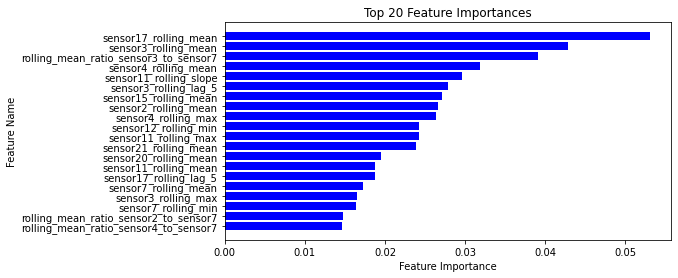

In [26]:
# Select features and target
X_train = train_df_scaled.drop(columns=['RUL', 'unit_id', 'cycle'])
y_train = train_df_scaled['RUL'] # Note: RUL is not scaled
X_test = test_df_scaled.drop(columns=['unit_id', 'cycle'])
y_test = RUL_df['RUL']

rf_model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [6, 9, 12],
    'min_samples_leaf': [4, 6, 8],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

grid_search_rf = fit_model(X_train, y_train, rf_model, param_grid)

# Best parameters
print(f'Best Parameters: {grid_search_rf.best_params_}')

best_rf_model = grid_search_rf.best_estimator_

# Make predictions
rf_res_df = get_best_rmse(best_rf_model, X_train, X_test)

plot_feature_importances(best_rf_model, X_train.columns, 20)

### 1.8 Build ramdom forest model using rolling features

Fitting 3 folds for each of 162 candidates, totalling 486 fits


c:\Users\owner\anaconda3\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 400}
Root Mean Squared Error (RMSE) for train set prediction: 9.560293900977067
Root Mean Squared Error (RMSE) for test set prediction: 33.34279593564298


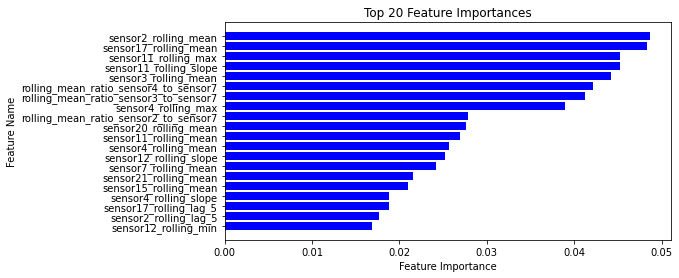

In [27]:
X_train_rolling = train_df_scaled.filter(like='rolling')
X_test_rolling = test_df_scaled.filter(like='rolling')

rf_rolling_model = RandomForestRegressor(random_state=42)

param_grid_rf_rolling = {
    'n_estimators': [200, 300, 400],
    'max_depth': [6, 8, 10],
    'min_samples_split': [6, 8, 10],
    'min_samples_leaf': [4, 6, 8],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

grid_search_rf_rolling = fit_model(X_train_rolling, y_train, rf_rolling_model, param_grid_rf_rolling)

# Best parameters
print(f'Best Parameters: {grid_search_rf_rolling.best_params_}')

best_rf_rolling_model = grid_search_rf_rolling.best_estimator_

# Make predictions
rf_rolling_res_df = get_best_rmse(best_rf_rolling_model, X_train_rolling, X_test_rolling)

plot_feature_importances(best_rf_rolling_model, X_train_rolling.columns, 20)

### 1.9 Build LightGBM model using all features

Fitting 3 folds for each of 1458 candidates, totalling 4374 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54234
[LightGBM] [Info] Number of data points in the train set: 16731, number of used features: 302
[LightGBM] [Info] Start training from score 79.353177
Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 30, 'n_estimators': 100, 'num_leaves': 10, 'reg_alpha': 1.0, 'subsample': 0.6}
Root Mean Squared Error (RMSE) for train set prediction: 5.9981015782404326
Root Mean Squared Error (RMSE) for test set prediction: 33.71070784715896


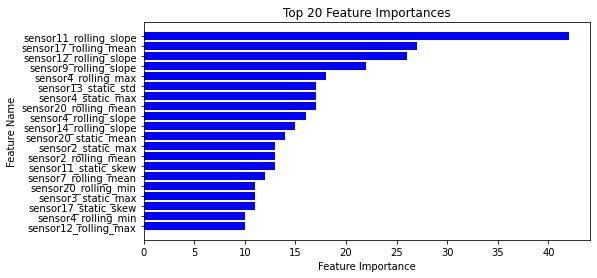

In [28]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(random_state=42)

param_grid_lgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [10, 15, 20],
    'min_child_samples': [20, 30, 40],
    'max_depth': [5, 7, 10],
    'subsample': [0.6, 0.8],
    'reg_alpha': [0.1, 0.5, 1.0]
}

grid_search_lgb = fit_model(X_train, y_train, lgb_model, param_grid_lgb)

# Best parameters
print(f'Best Parameters: {grid_search_lgb.best_params_}')

best_lgb_model = grid_search_lgb.best_estimator_

# Make predictions
lgb_res_df = get_best_rmse(best_lgb_model, X_train, X_test)

plot_feature_importances(best_lgb_model, X_train.columns, 20)

## Experiment 2: Various ML & DL Models Using Selected Sensors with Tsfresh

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh.feature_extraction import EfficientFCParameters


In [3]:
col_1 = ['unit', 'time', 'op1', 'op2', 'op3']
col_2 = [f'sr{i+1}' for i in range(21)]
columns = col_1 + col_2

# Load datasets and assign column names
df = pd.read_csv(r'C:\\Users\\owner\\Desktop\\IT5006\\CMAPSSData\\train_FD001.txt', delim_whitespace=True, header=None, names=columns)
test = pd.read_csv(r'C:\\Users\\owner\\Desktop\\IT5006\\CMAPSSData\\test_FD001.txt', delim_whitespace=True, header=None, names=columns)

# Add features to training data
df['max_time'] = df.groupby('unit')['time'].transform('max')
df['remaining_time'] = df['max_time'] - df['time']
df['label'] = df['remaining_time'].clip(upper=130)

# Preview data
df.head()

,unit,time,op1,op2,op3,sr1,sr2,sr3,sr4,sr5,...,sr15,sr16,sr17,sr18,sr19,sr20,sr21,max_time,remaining_time,label
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191,130
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190,130
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,189,130
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,192,188,130
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,192,187,130


In [4]:
test.head()

,unit,time,op1,op2,op3,sr1,sr2,sr3,sr4,sr5,...,sr12,sr13,sr14,sr15,sr16,sr17,sr18,sr19,sr20,sr21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


### 2.1 Exploratory data analysis

same as experiment 1, but we choose to remove all Operating system

### 2.2 Data preprocessing

In [5]:
window_size = 30

rolling_params = {
    "column_id": "unit",
    "column_sort": "time",
    "max_timeshift": window_size - 1,
    "min_timeshift": window_size-1,
    "rolling_direction": 1
}

rolled_df = roll_time_series(df, **rolling_params)

rolled_test = roll_time_series(test, **rolling_params)

Rolling: 100%|██████████| 51/51 [00:07<00:00,  6.48it/s]


In [6]:
rolled_df

,unit,time,op1,op2,op3,sr1,sr2,sr3,sr4,sr5,...,sr16,sr17,sr18,sr19,sr20,sr21,max_time,remaining_time,label,id
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,0.03,392,2388,100.0,39.06,23.4190,192,191,130,"(1, 30)"
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,0.03,392,2388,100.0,39.00,23.4236,192,190,130,"(1, 30)"
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,0.03,390,2388,100.0,38.95,23.3442,192,189,130,"(1, 30)"
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,0.03,392,2388,100.0,38.88,23.3739,192,188,130,"(1, 30)"
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,0.03,393,2388,100.0,38.90,23.4044,192,187,130,"(1, 30)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317935,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,0.03,397,2388,100.0,38.49,22.9735,200,4,4,"(100, 200)"
317936,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,0.03,395,2388,100.0,38.30,23.1594,200,3,3,"(100, 200)"
317937,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,0.03,398,2388,100.0,38.44,22.9333,200,2,2,"(100, 200)"
317938,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,0.03,395,2388,100.0,38.29,23.0640,200,1,1,"(100, 200)"


In [7]:
rolled_test

,unit,time,op1,op2,op3,sr1,sr2,sr3,sr4,sr5,...,sr13,sr14,sr15,sr16,sr17,sr18,sr19,sr20,sr21,id
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,"(1, 30)"
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,"(1, 30)"
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,"(1, 30)"
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,"(1, 30)"
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,"(1, 30)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297865,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,"(100, 198)"
297866,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,"(100, 198)"
297867,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,"(100, 198)"
297868,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,"(100, 198)"


### 2.3 Feature engineering with Tsfresh

In [8]:
selected_cols=['id','sr2', 'sr3', 'sr4',
                    'sr7', 'sr8', 'sr9', 'sr11',
                    'sr12', 'sr13', 'sr14', 'sr15',
                    'sr17', 'sr20', 'sr21']

selected_df=rolled_df[selected_cols]
selected_test=rolled_test[selected_cols]

In [9]:
extraction_settings = EfficientFCParameters()

feature_params = {
    "column_id": "id",
    "impute_function": impute,
    "default_fc_parameters": extraction_settings
}

X = extract_features(selected_df, **feature_params)
x_test = extract_features(selected_test, **feature_params)

Feature Extraction: 100%|██████████| 60/60 [06:47<00:00,  6.80s/it] 


In [10]:
print(X.shape)
print(x_test.shape)

(17731, 10878)
(10196, 10878)


### 2.4 Feature selection with Tsfresh 

In [11]:
y=rolled_df.groupby('id')['label'].last()
X_filtered=select_features(X, y)
X_filtered

sr2__sum_values  \
1   30          19269.85   
    31          19270.05   
    32          19270.23   
    33          19270.59   
    34          19270.78   
...                  ...   
100 196         19298.93   
    197         19298.90   
    198         19299.35   
    199         19299.73   
    200         19300.87   

         sr11__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)  \
1   30                                          156.409278              
    31                                          156.368864              
    32                                          156.327455              
    33                                          156.337849              
    34                                          156.368555              
...                                                    ...              
100 196                                         158.568891              
    197                                         158.623532              
    198                                         158.652266              
    199                                         158.656074              
    200                                         158.658267              

         sr11__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)  \
1   30                                          128.188893              
    31                                          128.148081              
    32                                          128.111992              
    33                                          128.093719              
    34                                          128.106191              
...                                                    ...              
100 196                                         129.953109              
    197                                         129.937525              
    198                                         129.946629              
    199                                         129.935184              
    200                                         129.913791              

         sr11__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)  \
1   30                                           56.615794             
    31                                           56.598901             
    32                                           56.614797             
    33                                           56.625047             
    34                                           56.629328             
...                                                    ...             
100 196                                          57.574056             
    197                                          57.536227             
    198                                          57.488897             
    199                                          57.445022             
    200                                          57.403520             

         sr11__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)  \
1   30                                          148.261847              
    31                                          148.214965              
    32                                          148.171099              
    33                                          148.167666              
    34                                          148.202226              
...                                                    ...              
100 196                                         150.287973              
    197                                         150.324517              
    198                                         150.370527              
    199                                         150.373369              
    200                                         150.368545              

         sr11__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)  \
1   30                                          120.420258              
    31                        

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_filtered)
relevant_features_scaled = scaler.transform(X_filtered)
relevant_features_scaled_df = pd.DataFrame(relevant_features_scaled, columns=X_filtered.columns)

selected_features = relevant_features_scaled_df.columns 
relevant_test_features = x_test[selected_features]
relevant_test_features_scaled = scaler.transform(relevant_test_features)
relevant_test_features_scaled_df = pd.DataFrame(relevant_test_features_scaled, columns=selected_features)

In [13]:
print(selected_features)

Index(['sr2__sum_values',
       'sr11__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)',
       'sr11__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)',
       'sr11__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)',
       'sr11__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)',
       'sr11__cwt_coefficients__coeff_5__w_10__widths_(2, 5, 10, 20)',
       'sr11__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)',
       'sr11__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)',
       'sr11__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)',
       'sr11__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)',
       ...
       'sr13__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2',
       'sr21__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.6',
       'sr7__lempel_ziv_complexity__bins_2', 'sr15__fourier_entropy__bins_10',
       'sr11__sum_of_reoccurring_values',
       'sr13__change_quantiles__f_agg_"var"__isabs_True__q

In [14]:
print(relevant_features_scaled_df.shape)
print(relevant_test_features_scaled_df.shape)

(17731, 4237)
(10196, 4237)


### 2.5 Predictive modeling

In [15]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(relevant_features_scaled_df, y, test_size=0.2, random_state=42)

In [16]:
rul_file_path = 'C:\\Users\\owner\\Desktop\\IT5006\\CMAPSSData\\RUL_FD001.txt'
true_rul = pd.read_csv(rul_file_path, header=None, names=['RUL'])
true_rul['RUL'] = true_rul['RUL'].clip(upper=130)

# Assign the true RUL values to Y_test
y_test = true_rul['RUL']

In [17]:
def calculate_s_score(y_true, y_pred):
    # Calculate the error between predictions and actual values
    error = y_pred - y_true
    
    # Apply S-score calculation
    s_score = np.where(
        error <= 0, 
        np.exp(-error / 13) - 1, 
        np.exp(error / 10) - 1
    )
    
    # Return the mean S-score
    return np.mean(s_score)


def evaluate_model(model, X_train, y_train, X_val, y_val, X_test=None, Y_test=None):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on validation set
    y_pred = model.predict(X_val)
    
    # Calculate evaluation metrics for validation
    s_score = calculate_s_score(y_val, y_pred)
    mse_val = mean_squared_error(y_val, y_pred)
    rmse_val = mse_val ** 0.5
    
    # Print validation results
    model_name = model.__class__.__name__
    print(f'{model_name} model - Validation Set')
    print('RMSE:', rmse_val)
    print('S-score:', s_score)
    print('---------------------')
    
    results = {'model': model_name, 'rmse_val': rmse_val, 's_score': s_score}
    
    # If test set provided, predict and evaluate on test set
    if X_test is not None and Y_test is not None:
        y_pred_test = model.predict(X_test)
        temp = rolled_test.groupby('id').last()
        temp['prediction'] = y_pred_test
        Y_pred = temp.groupby('unit')['prediction'].last().to_numpy()
        
        # Calculate RMSE for test set
        s_test = calculate_s_score(Y_test, Y_pred)
        mse_test = mean_squared_error(Y_test, Y_pred)
        rmse_test = mse_test ** 0.5
        print(f'{model_name} model - Test Set')
        print('Test RMSE:', rmse_test)
        print('Test score:', s_test)
        print('---------------------')
        
        # Store test results in the results dictionary
        results.update({'rmse_test': rmse_test, 'test_score': s_test})
    
    return results

In [18]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.base import BaseEstimator, RegressorMixin


def scheduler(epoch, optimizer):
    if epoch < 5:
        lr = 0.001
    else:
        lr = 0.0001
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


class ConvLSTMModel(nn.Module):
    def __init__(self, input_channels, drop_CNN=0.1, drop_dense=0.1, kernel_size=3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=128, kernel_size=kernel_size, padding=kernel_size//2)
        self.dropout1 = nn.Dropout(p=drop_CNN)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2, padding=1)

        self.conv2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=kernel_size, padding=kernel_size//2)
        self.dropout2 = nn.Dropout(p=drop_CNN)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=1)

        self.lstm1 = nn.LSTM(input_size=128, hidden_size=128, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, num_layers=1, batch_first=True)

        self.dropout3 = nn.Dropout(p=drop_dense)
        self.dense1 = nn.Linear(128, 512)
        self.dense2 = nn.Linear(512, 128)
        self.dense3 = nn.Linear(128, 1)

    def forward(self, x):
        # x shape: (batch_size, window_length, input_channels)
        x = x.permute(0, 2, 1)  # Convert to (batch_size, input_channels, window_length)
        x = F.relu(self.conv1(x))
        x = self.dropout1(x)
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.dropout2(x)
        x = self.pool2(x)

        x = x.permute(0, 2, 1)  # Convert to (batch_size, seq_length, channels)

        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]

        # Dropout layer
        x = self.dropout3(x)

        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = self.dense3(x)
        
        return x


class ConvLSTMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_channels=1, lr=0.001, batch_size=64, max_epoch=500, drop_CNN=0.1, drop_dense=0.1, kernel_size=3):
        self.lr = lr
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.model = ConvLSTMModel(input_channels=input_channels, drop_CNN=drop_CNN, drop_dense=drop_dense, kernel_size=kernel_size)

    def _prepare_input(self, X):
        """
        Detect input data dimensions:
        If the input is two-dimensional data (samples, features), a pseudo-time dimension is added (samples, 1, features).
        If the input is three-dimensional data (samples, seq_length, channels), it is returned directly.
        """
        if X.ndim == 2:
            X = np.expand_dims(X, axis=1)  # 增加伪时间维度
        return X

        
    def fit(self, X, y):
        # Detect and adjust input data dimensions
        X = self._prepare_input(X)

        # Convert X, y to torch tensors
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

        # Define optimizer
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.MSELoss()

        # Training loop
        self.model.train()
        for epoch in range(self.max_epoch):
            running_loss = 0.0
            permutation = torch.randperm(X_tensor.size(0))
            for i in range(0, X_tensor.size(0), self.batch_size):
                indices = permutation[i:i + self.batch_size]
                batch_x, batch_y = X_tensor[indices], y_tensor[indices]

                optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            if (epoch + 1) % 1 == 0:
                print(f"Epoch {epoch + 1}/{self.max_epoch}, Loss: {running_loss/X_tensor.size(0):.4f}")

            # adjust learning rate based on epoch
            scheduler(epoch, optimizer)

        return self

    def predict(self, X):
        # Detect and adjust input data dimensions
        X = self._prepare_input(X)

        # Convert X to torch tensor
        X_tensor = torch.tensor(X, dtype=torch.float32)
        
        # Prediction
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(X_tensor).numpy()
        
        return predictions.flatten()


In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
# from cnn_lstm import ConvLSTMRegressor

# List of models to evaluate
models = [XGBRegressor(objective='reg:squarederror',random_state=42,n_estimators=50,max_depth=6,min_child_weight=5,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,tree_method='hist'),
          RandomForestRegressor(n_estimators=50,max_depth=15,max_features="sqrt",min_samples_split=10,min_samples_leaf=5,n_jobs=-1),
          MLPRegressor(hidden_layer_sizes=(50, 50), solver="adam", batch_size=64, learning_rate="adaptive", learning_rate_init=0.01, max_iter=500),
          ConvLSTMRegressor(input_channels=X_train.shape[-1], batch_size=64, lr=0.001, max_epoch=10)]

# Evaluate each model
results = []
for model in models:
    result = evaluate_model(model, X_train, y_train, X_val, y_val, X_test=relevant_test_features_scaled_df, Y_test=y_test)
    results.append(result)

# If you want, you can compile the results into a DataFrame for easy comparison

results_df = pd.DataFrame(results)
print(results_df)

XGBRegressor model - Validation Set
RMSE: 8.451915091273627
S-score: 1.1923859446054015
---------------------
XGBRegressor model - Test Set
Test RMSE: 13.307124415638445
Test score: 2.9278578175772108
---------------------
RandomForestRegressor model - Validation Set
RMSE: 8.938327871319386
S-score: 1.3525983994910127
---------------------
RandomForestRegressor model - Test Set
Test RMSE: 13.778483738260226
Test score: 2.9563511629715475
---------------------
MLPRegressor model - Validation Set
RMSE: 5.302033174269726
S-score: 0.5685581314387693
---------------------
MLPRegressor model - Test Set
Test RMSE: 16.54999206488271
Test score: 5.660611849010689
---------------------
Epoch 1/10, Loss: 21.4591
Epoch 2/10, Loss: 1.0654
Epoch 3/10, Loss: 0.5719
Epoch 4/10, Loss: 0.4383
Epoch 5/10, Loss: 0.3542
Epoch 6/10, Loss: 0.3287
Epoch 7/10, Loss: 0.2573
Epoch 8/10, Loss: 0.2376
Epoch 9/10, Loss: 0.2287
Epoch 10/10, Loss: 0.2190
ConvLSTMRegressor model - Validation Set
RMSE: 3.20914808434404

### 2.6 PCA dimension reduction to prevent overfitting

result did not improve after PCA dimension reduction

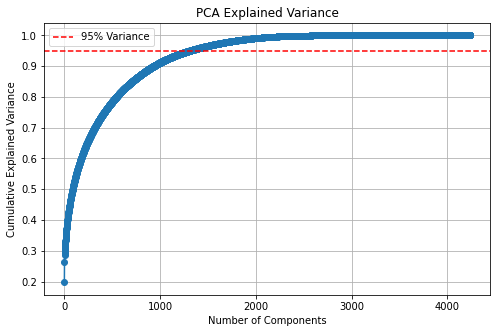

Optimal number of components for 95% variance: 1308


In [20]:
from sklearn.decomposition import PCA
pca = PCA()  # Adjust based on your dataset
pca.fit(X_train)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.legend()
plt.grid(True)
plt.show()

# Find the optimal number of components to retain at least 95% variance
optimal_n_components = np.argmax(cumulative_variance >= 0.95) + 1
print("Optimal number of components for 95% variance:", optimal_n_components)

In [21]:
pca = PCA(n_components=optimal_n_components)  # Adjust based on your dataset
X_train_reduced = pca.fit_transform(X_train)
X_val_reduced = pca.transform(X_val)
X_test_reduced = pca.transform(relevant_test_features_scaled_df)

In [22]:
# List of models to evaluate
models = [XGBRegressor(objective='reg:squarederror',random_state=42,n_estimators=50,max_depth=6,min_child_weight=5,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,tree_method='hist'),
          RandomForestRegressor(n_estimators=50,max_depth=15,max_features="sqrt",min_samples_split=10,min_samples_leaf=5,n_jobs=-1),
          MLPRegressor(hidden_layer_sizes=(50, 50), solver="adam", batch_size=64, learning_rate="adaptive", learning_rate_init=0.01, max_iter=500),
          ConvLSTMRegressor(input_channels=X_train_reduced.shape[-1], batch_size=64, lr=0.001, max_epoch=10)]

# Evaluate each model
results = []
for model in models:
    result = evaluate_model(model, X_train_reduced, y_train, X_val_reduced, y_val, X_test=X_test_reduced, Y_test=y_test)
    results.append(result)

# If you want, you can compile the results into a DataFrame for easy comparison
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

XGBRegressor model - Validation Set
RMSE: 10.385826483628279
S-score: 1.816593818900785
---------------------
XGBRegressor model - Test Set
Test RMSE: 14.046959253082614
Test score: 3.1818481351111227
---------------------
RandomForestRegressor model - Validation Set
RMSE: 29.209209809929412
S-score: 20.91919514820549
---------------------
RandomForestRegressor model - Test Set
Test RMSE: 28.450726798335413
Test score: 24.153147797493133
---------------------
MLPRegressor model - Validation Set
RMSE: 6.744513437454708
S-score: 0.8186199462153082
---------------------
MLPRegressor model - Test Set
Test RMSE: 17.11003647836608
Test score: 5.605691842552561
---------------------
Epoch 1/10, Loss: 20.3311
Epoch 2/10, Loss: 1.2492
Epoch 3/10, Loss: 0.8290
Epoch 4/10, Loss: 0.6150
Epoch 5/10, Loss: 0.5172
Epoch 6/10, Loss: 0.4514
Epoch 7/10, Loss: 0.3487
Epoch 8/10, Loss: 0.3097
Epoch 9/10, Loss: 0.2767
Epoch 10/10, Loss: 0.2585
ConvLSTMRegressor model - Validation Set
RMSE: 4.95907767140907

### 2.7 Residual plot

result did not improve after PCA dimension reduction

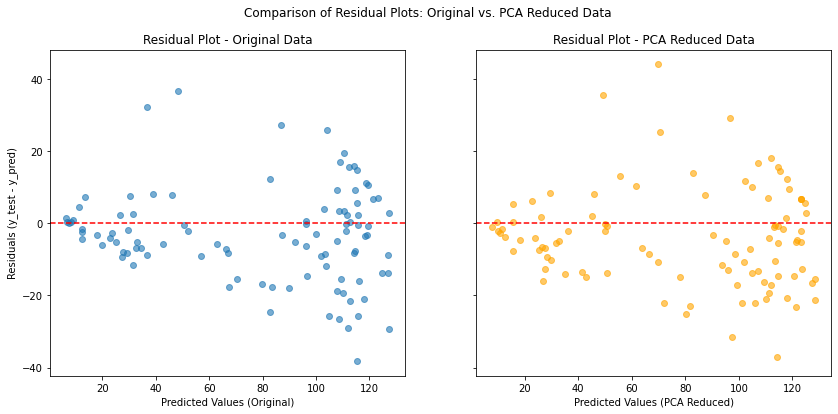

In [23]:
XGBoost= XGBRegressor(objective='reg:squarederror',random_state=42,n_estimators=50,max_depth=6,min_child_weight=5,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,tree_method='hist')
XGBoost.fit(X_train, y_train)
y_pred = XGBoost.predict(relevant_test_features_scaled_df)
temp = rolled_test.groupby('id').last()
temp['prediction'] = y_pred
y_pred_original = temp.groupby('unit')['prediction'].last().to_numpy()

XGBoost= XGBRegressor(objective='reg:squarederror',random_state=42,n_estimators=50,max_depth=6,min_child_weight=5,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,tree_method='hist')
XGBoost.fit(X_train_reduced, y_train)
y_pred = XGBoost.predict(X_test_reduced)
temp = rolled_test.groupby('id').last()
temp['prediction'] = y_pred
y_pred_pca = temp.groupby('unit')['prediction'].last().to_numpy()

residuals_original = y_test - y_pred_original
residuals_pca = y_test - y_pred_pca

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Original data residual plot
axes[0].scatter(y_pred_original, residuals_original, alpha=0.6)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_xlabel("Predicted Values (Original)")
axes[0].set_ylabel("Residuals (y_test - y_pred)")
axes[0].set_title("Residual Plot - Original Data")

# PCA-reduced data residual plot
axes[1].scatter(y_pred_pca, residuals_pca, alpha=0.6, color="orange")
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_xlabel("Predicted Values (PCA Reduced)")
axes[1].set_title("Residual Plot - PCA Reduced Data")

plt.suptitle("Comparison of Residual Plots: Original vs. PCA Reduced Data")
plt.show()

### 2.8 Feature importance

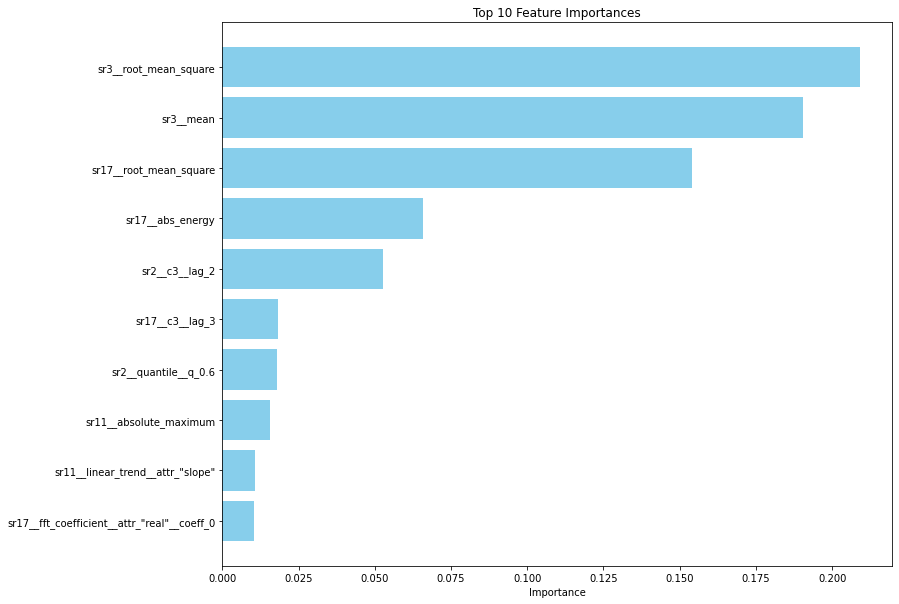

In [24]:
XGBoost= XGBRegressor(objective='reg:squarederror',random_state=42,n_estimators=50,max_depth=6,min_child_weight=5,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,tree_method='hist')
XGBoost.fit(X_train, y_train)

# Get feature importances
importances = XGBoost.feature_importances_

# Create a DataFrame for easy sorting and selection
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,  # Adjust if feature names are in a different variable
    'Importance': importances
})

# Sort by importance and select the top 100 features
top_10_features = feature_importances.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(12, 10))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances")
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.show()

## Experiment 3: Various ML & DL Models Using All Features with Tsfresh

In [8]:
#select and extract features (uses all sensors)
selected_cols=['id', 'sr1','sr2', 'sr3', 'sr4', 'sr5',
               'sr6', 'sr7', 'sr8', 'sr9', 'sr10',
                'sr11', 'sr12', 'sr13', 'sr14', 'sr15',
                'sr16', 'sr17', 'sr18', 'sr19', 'sr20', 'sr21']
selected_df=rolled_df[selected_cols]
selected_test=rolled_test[selected_cols]

In [13]:
extraction_settings = EfficientFCParameters()
feature_params = {
    "column_id": "id",
    "impute_function": impute,
    "default_fc_parameters": extraction_settings
}

X = extract_features(selected_df, **feature_params)
x_test = extract_features(selected_test, **feature_params)

print(X.shape)
print(x_test.shape)

Feature Extraction: 100%|██████████| 60/60 [09:07<00:00,  9.13s/it]  


(17731, 16317)
(10196, 16317)


In [14]:
y=rolled_df.groupby('id')['label'].last()
X_filtered=select_features(X, y)
X_filtered

sr2__sum_values  \
1   30          19269.85   
    31          19270.05   
    32          19270.23   
    33          19270.59   
    34          19270.78   
...                  ...   
100 196         19298.93   
    197         19298.90   
    198         19299.35   
    199         19299.73   
    200         19300.87   

         sr15__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)  \
1   30                                           29.217642              
    31                                           29.217530              
    32                                           29.213309              
    33                                           29.211379              
    34                                           29.219420              
...                                                    ...              
100 196                                          29.511664              
    197                                          29.515914              
    198                                          29.517043              
    199                                          29.518587              
    200                                          29.517111              

         sr15__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)  \
1   30                                           23.881620              
    31                                           23.880309              
    32                                           23.882483              
    33                                           23.886501              
    34                                           23.891524              
...                                                    ...              
100 196                                          24.130337              
    197                                          24.136323              
    198                                          24.135187              
    199                                          24.135389              
    200                                          24.136678              

         sr15__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)  \
1   30                                            9.102839             
    31                                            9.103483             
    32                                            9.109627             
    33                                            9.115923             
    34                                            9.114446             
...                                                    ...             
100 196                                           9.198008             
    197                                           9.196242             
    198                                           9.201487             
    199                                           9.209944             
    200                                           9.222888             

         sr15__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)  \
1   30                                           27.833924              
    31                                           27.832365              
    32                                           27.830229              
    33                                           27.828312              
    34                                           27.834542              
...                                                    ...              
100 196                                          28.114293              
    197                                          28.118605              
    198                                          28.117803              
    199                                          28.119624              
    200                                          28.119341              

         sr11__sum_values  sr11__abs_energy  \
1   30            1418.48        67069.9104   
    31            1418.42        67064.2176   
    32            1418.18        67

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_filtered)
relevant_features_scaled = scaler.transform(X_filtered)
relevant_features_scaled_df = pd.DataFrame(relevant_features_scaled, columns=X_filtered.columns)

selected_features = relevant_features_scaled_df.columns 
relevant_test_features = x_test[selected_features]
relevant_test_features_scaled = scaler.transform(relevant_test_features)
relevant_test_features_scaled_df = pd.DataFrame(relevant_test_features_scaled, columns=selected_features)

print(relevant_features_scaled_df.shape)
print(relevant_test_features_scaled_df.shape)

(17731, 4524)
(10196, 4524)


In [16]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(relevant_features_scaled_df, y, test_size=0.2, random_state=42)

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
# from cnn_lstm import ConvLSTMRegressor

models = [XGBRegressor(objective='reg:squarederror',random_state=42,n_estimators=50,max_depth=6,min_child_weight=5,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,tree_method='hist'),
          RandomForestRegressor(n_estimators=50,max_depth=15,max_features="sqrt",min_samples_split=10,min_samples_leaf=5,n_jobs=-1),
          MLPRegressor(hidden_layer_sizes=(50, 50), solver="adam", batch_size=64, learning_rate="adaptive", learning_rate_init=0.01, max_iter=500),
          ConvLSTMRegressor(input_channels=X_train.shape[-1], batch_size=64, lr=0.001, max_epoch=10)]

# Evaluate each model
results = []
for model in models:
    result = evaluate_model(model, X_train, y_train, X_val, y_val, X_test=relevant_test_features_scaled_df, Y_test=y_test)
    results.append(result)

# If you want, you can compile the results into a DataFrame for easy comparison

results_df = pd.DataFrame(results)
print(results_df)

XGBRegressor model - Validation Set
RMSE: 8.561010127719598
S-score: 1.2244383324695107
---------------------
XGBRegressor model - Test Set
Test RMSE: 13.385364275508744
Test score: 2.762444774689477
---------------------
RandomForestRegressor model - Validation Set
RMSE: 8.686037714161406
S-score: 1.2988080610758383
---------------------
RandomForestRegressor model - Test Set
Test RMSE: 13.932169475750415
Test score: 3.135292513448074
---------------------
MLPRegressor model - Validation Set
RMSE: 3.9409443559428263
S-score: 0.3531721016730645
---------------------
MLPRegressor model - Test Set
Test RMSE: 15.261884556129095
Test score: 4.9976698076070445
---------------------
Epoch 1/10, Loss: 21.9478
Epoch 2/10, Loss: 1.1503
Epoch 3/10, Loss: 0.6470
Epoch 4/10, Loss: 0.4801
Epoch 5/10, Loss: 0.3784
Epoch 6/10, Loss: 0.3298
Epoch 7/10, Loss: 0.2639
Epoch 8/10, Loss: 0.2337
Epoch 9/10, Loss: 0.2225
Epoch 10/10, Loss: 0.2160
ConvLSTMRegressor model - Validation Set
RMSE: 3.2600693128271

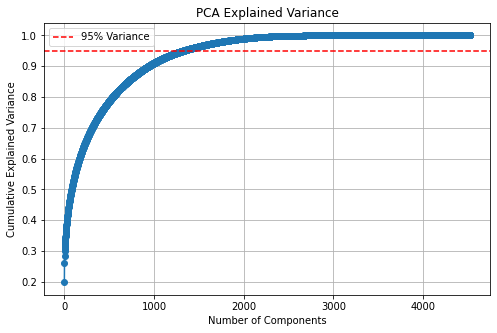

Optimal number of components for 95% variance: 1326


In [23]:
from sklearn.decomposition import PCA
pca = PCA()  # Adjust based on your dataset
pca.fit(X_train)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.legend()
plt.grid(True)
plt.show()

# Find the optimal number of components to retain at least 95% variance
optimal_n_components = np.argmax(cumulative_variance >= 0.95) + 1
print("Optimal number of components for 95% variance:", optimal_n_components)

In [24]:
pca = PCA(n_components=optimal_n_components)  # Adjust based on your dataset
X_train_reduced = pca.fit_transform(X_train)
X_val_reduced = pca.transform(X_val)
X_test_reduced = pca.transform(relevant_test_features_scaled_df)

In [25]:
# List of models to evaluate
models = [XGBRegressor(objective='reg:squarederror',random_state=42,n_estimators=50,max_depth=6,min_child_weight=5,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,tree_method='hist'),
          RandomForestRegressor(n_estimators=50,max_depth=15,max_features="sqrt",min_samples_split=10,min_samples_leaf=5,n_jobs=-1),
          MLPRegressor(hidden_layer_sizes=(50, 50), solver="adam", batch_size=64, learning_rate="adaptive", learning_rate_init=0.01, max_iter=500),
          ConvLSTMRegressor(input_channels=X_train_reduced.shape[-1], batch_size=64, lr=0.001, max_epoch=10)]

# Evaluate each model
results = []
for model in models:
    result = evaluate_model(model, X_train_reduced, y_train, X_val_reduced, y_val, X_test=X_test_reduced, Y_test=y_test)
    results.append(result)

# If you want, you can compile the results into a DataFrame for easy comparison
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

XGBRegressor model - Validation Set
RMSE: 10.548209671388998
S-score: 1.8611245771361589
---------------------
XGBRegressor model - Test Set
Test RMSE: 14.835708535693904
Test score: 4.410333578954102
---------------------
RandomForestRegressor model - Validation Set
RMSE: 27.786728304059476
S-score: 17.09672675197352
---------------------
RandomForestRegressor model - Test Set
Test RMSE: 26.72025906104367
Test score: 19.753076619916772
---------------------
MLPRegressor model - Validation Set
RMSE: 5.012055974234384
S-score: 0.4812287870884534
---------------------
MLPRegressor model - Test Set
Test RMSE: 15.084147669411479
Test score: 3.6402775093544473
---------------------
Epoch 1/10, Loss: 19.0601
Epoch 2/10, Loss: 1.1577
Epoch 3/10, Loss: 0.7833
Epoch 4/10, Loss: 0.5980
Epoch 5/10, Loss: 0.4882
Epoch 6/10, Loss: 0.4026
Epoch 7/10, Loss: 0.3300
Epoch 8/10, Loss: 0.2855
Epoch 9/10, Loss: 0.2697
Epoch 10/10, Loss: 0.2530
ConvLSTMRegressor model - Validation Set
RMSE: 4.6922957756851

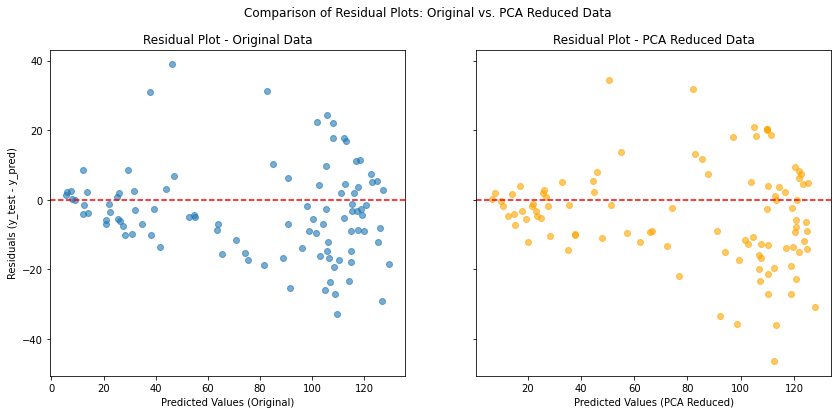

In [26]:
XGBoost= XGBRegressor(objective='reg:squarederror',random_state=42,n_estimators=50,max_depth=6,min_child_weight=5,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,tree_method='hist')
XGBoost.fit(X_train, y_train)
y_pred = XGBoost.predict(relevant_test_features_scaled_df)
temp = rolled_test.groupby('id').last()
temp['prediction'] = y_pred
y_pred_original = temp.groupby('unit')['prediction'].last().to_numpy()

XGBoost= XGBRegressor(objective='reg:squarederror',random_state=42,n_estimators=50,max_depth=6,min_child_weight=5,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,tree_method='hist')
XGBoost.fit(X_train_reduced, y_train)
y_pred = XGBoost.predict(X_test_reduced)
temp = rolled_test.groupby('id').last()
temp['prediction'] = y_pred
y_pred_pca = temp.groupby('unit')['prediction'].last().to_numpy()

residuals_original = y_test - y_pred_original
residuals_pca = y_test - y_pred_pca

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Original data residual plot
axes[0].scatter(y_pred_original, residuals_original, alpha=0.6)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_xlabel("Predicted Values (Original)")
axes[0].set_ylabel("Residuals (y_test - y_pred)")
axes[0].set_title("Residual Plot - Original Data")

# PCA-reduced data residual plot
axes[1].scatter(y_pred_pca, residuals_pca, alpha=0.6, color="orange")
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_xlabel("Predicted Values (PCA Reduced)")
axes[1].set_title("Residual Plot - PCA Reduced Data")

plt.suptitle("Comparison of Residual Plots: Original vs. PCA Reduced Data")
plt.show()

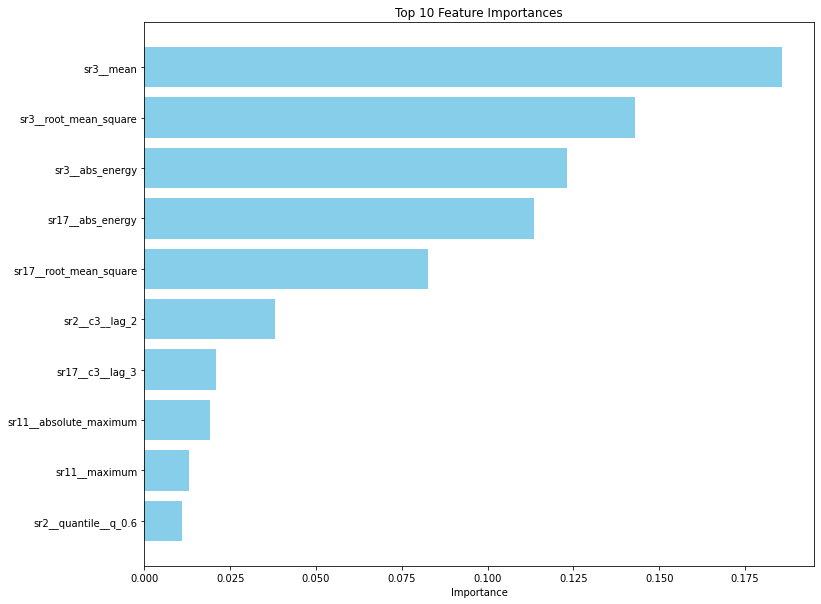

In [27]:
XGBoost= XGBRegressor(objective='reg:squarederror',random_state=42,n_estimators=50,max_depth=6,min_child_weight=5,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,tree_method='hist')
XGBoost.fit(X_train, y_train)

# Get feature importances
importances = XGBoost.feature_importances_

# Create a DataFrame for easy sorting and selection
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,  # Adjust if feature names are in a different variable
    'Importance': importances
})

# Sort by importance and select the top 100 features
top_10_features = feature_importances.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(12, 10))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances")
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.show()

## Mean Predictor Model (Baseline Reference)

In [28]:
y_mean_pred =[sum(y_test)/len(y_test)]* len(y_test)
rmse_mean_pred = np.sqrt(mean_squared_error(y_test, y_mean_pred))
print(f'Root Mean Squared Error (RMSE)for mean predictor: {rmse_mean_pred}')

Root Mean Squared Error (RMSE)for mean predictor: 40.68603691685884
